# Predicting daily bikerider count from temperature and weekday

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

import scipy.stats as stats

# import custom functions for data loading and plotting
import sys  
sys.path.insert(0, './../modules')
import m_data_loading as mdl
import m_plotting as mplot

## Import data

We import a dataset that contains the daily number of bike riders at a counting station in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.') in 2021 as well as the daily average temperature and a boolean whether a given day is a business day.

In [175]:
# counting station and time period
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2021, 12, 31)

# import data
combined_daily_dat = mdl.get_data_for_location(city_name, counter_site, channel_name, start_date, end_date)

In [176]:
# inspect
combined_daily_dat

,standort,counter_site,channel_name,longitude,latitude,date,temperature,is_busday,rider_count
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-01,1.4,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-02,0.8,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-03,-0.5,False,764
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-04,0.0,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-01-05,-0.7,True,1668
...,...,...,...,...,...,...,...,...,...
348,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-26,6.3,False,482
349,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-27,7.0,True,1395
350,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-28,10.0,True,1357
351,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,7.862301,47.99054,2021-12-29,9.7,True,1299


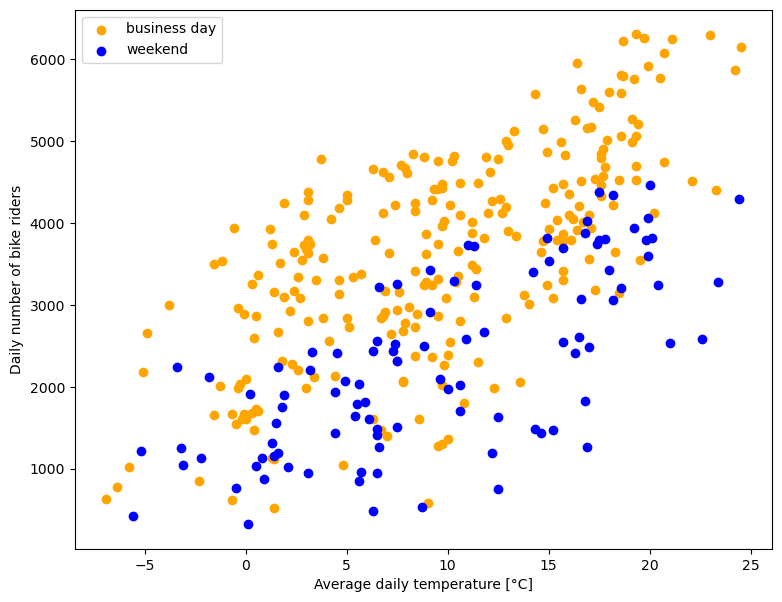

In [179]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.figure(figsize=(9,7))
plt.title(city_name + '\ncounter site: ' + counter_site + '\nchannel name: ' + channel_name);
mplot.plot_data()

## Statistical Analysis: Multiple Linear Regression

Independent variables:  
$x_1$: daily average temperature [°C]  
$x_2$: indicator variable whether day is a business day $\{0,1\}$

Dependent variable:  
$y$: daily bike rider count


Multiple linear regression:  

$$\mu = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2$$
$$y \sim \mathcal{N}(\mu, \sigma) $$


$\beta_0$: intercept on non-business days (i.e., bike rider count at $0°C$ on the weekend)  
$\beta_1$: slope on non-business days (weekends)  
$\beta_2$: additional intercept on business days  
$\beta_3$: interaction parameter (additional slope on business days)

So:
- on weeekends (i.e., $x_2 = 0$): $$\mu = \beta_0 + \beta_1 x_1$$
- on business days (i.e., $x_2 = 1$): $$\mu = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) x_1$$

### Gaussian data distribution

In [185]:
# fit linear Gaussian model to the daily bike rider counts data,
# predictors: mean day temperature and being a business day

fit_daily_counts = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat).fit()

# check the fit result
print(fit_daily_counts.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  353
Model:                            GLM   Df Residuals:                      349
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                      8.1123e+05
Method:                          IRLS   Log-Likelihood:                -2900.4
Date:                Sat, 14 Jan 2023   Deviance:                   2.8312e+08
Time:                        13:31:20   Pearson chi2:                 2.83e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7273
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

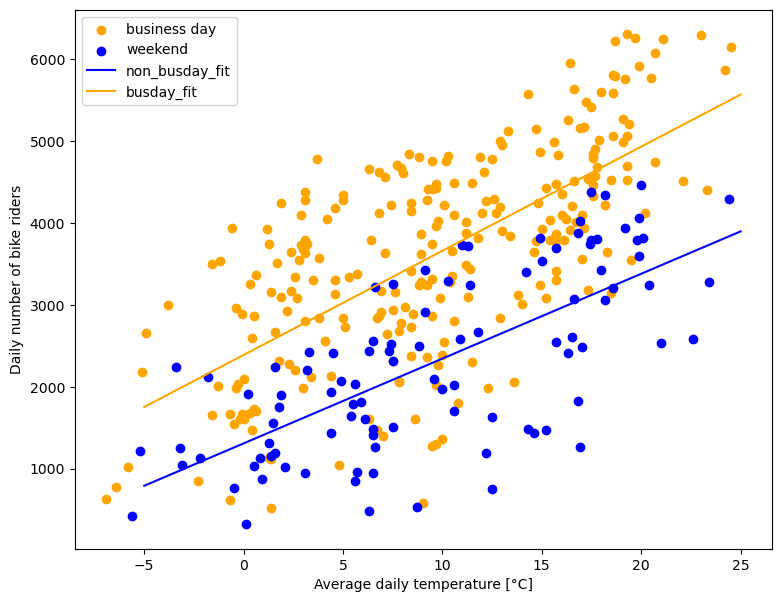

In [186]:
plt.figure(figsize=(9,7))
mplot.plot_data_and_linear_fit(
    fit_daily_counts.params['Intercept'],
    fit_daily_counts.params['temperature'],
    fit_daily_counts.params['is_busday[T.True]'],
    fit_daily_counts.params['temperature:is_busday[T.True]']
)

##### Check some of the model assumptions

Normal distribution of residuals?

In [187]:
type(fit_daily_counts.resid_response)

pandas.core.series.Series

In [188]:
def plot_residual_dist(residuals, xlabel):
    '''
    Plot histogram of given residuals.

    Parameters
    ----------
    residuals : pd.Series of float
        Residuals to plot.
    xlabel : str
        Label of x-axis.
    '''
    # inspect residuals
    bins=np.linspace(-3000., 3000., 37)
    x = np.linspace(-3000., 3000., 41)

    # plot residuals
    plt.hist(residuals, bins, color='b', density=True)

    # estimate Gaussian distribution for residuals
    mu, sigma = (residuals.mean(), residuals.std())
    plt.plot(x, stats.norm(mu, sigma).pdf(x), 'r--')

    # labels
    plt.xlabel(xlabel)
    plt.ylabel('rel. frequency');

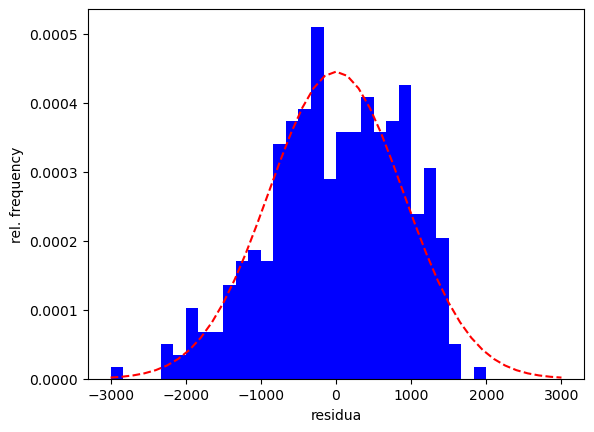

In [189]:
plot_residual_dist(fit_daily_counts.resid_response, 'residua')

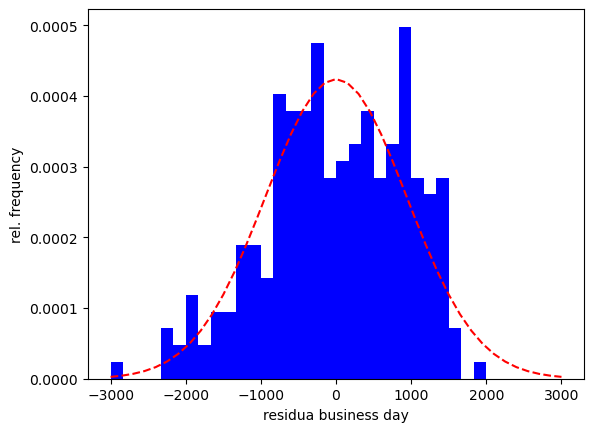

In [190]:
plot_residual_dist(fit_daily_counts.resid_response[combined_daily_dat[combined_daily_dat['is_busday']].index], 'residua business day')

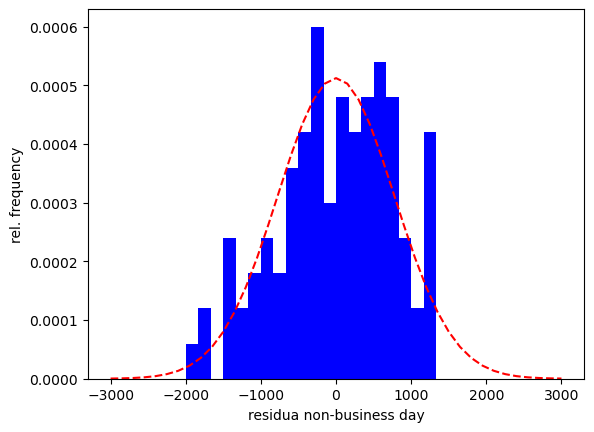

In [191]:
plot_residual_dist(fit_daily_counts.resid_response[combined_daily_dat[~combined_daily_dat['is_busday']].index], 'residua non-business day')

Seems a bit skewed. In left tail more than right.

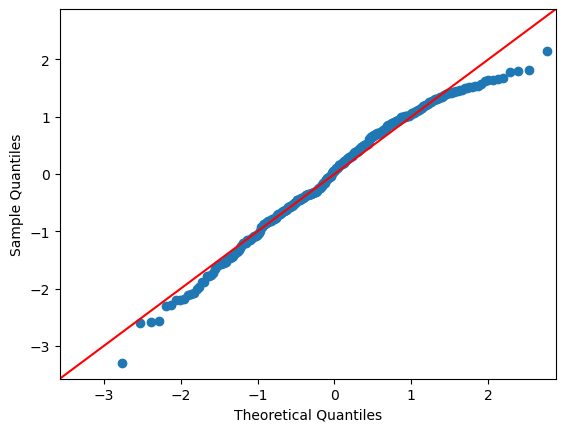

In [192]:
fig = sm.qqplot(fit_daily_counts.resid_response, stats.t, fit=True, line="45")
plt.show()

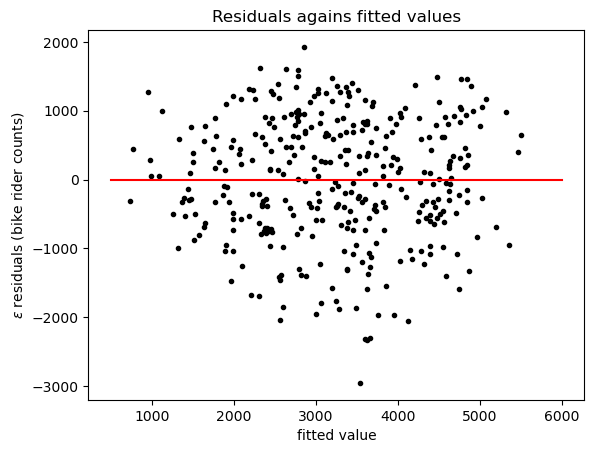

In [193]:
# inspect residuals: residuals vs fits
plt.plot(fit_daily_counts.predict(combined_daily_dat), fit_daily_counts.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('Residuals agains fitted values');

#### Same same but different: Again, "Linear Regression: Gaussian model with identity link function", Frequentist, but with "smf.ols" to get more summary data

In [194]:
# try different fit method to get more summary data
fit_daily_counts_ols = smf.ols(formula="rider_count ~ temperature * is_busday", data=combined_daily_dat).fit()
print(fit_daily_counts_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            rider_count   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     152.9
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           2.92e-63
Time:                        13:31:22   Log-Likelihood:                -2900.4
No. Observations:                 353   AIC:                             5809.
Df Residuals:                     349   BIC:                             5824.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### Poisson data distribution

In [253]:
# fit a poisson model with identity link function to the daily bike rider counts data,
# predictors: mean day temperature and being a business day
fit_daily_counts_poisson_identity = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat,
    family=sm.families.Poisson(link=sm.families.links.identity())).fit()

# check the fit result
print(fit_daily_counts_poisson_identity.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  353
Model:                            GLM   Df Residuals:                      349
Model Family:                 Poisson   Df Model:                            3
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52500.
Date:                Sat, 14 Jan 2023   Deviance:                   1.0154e+05
Time:                        13:35:51   Pearson chi2:                 9.37e+04
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/home/maren/anaconda3/envs/data_literacy_project_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Warning refers to: The linear relationship might predict negative parameter values for the Poisson distribution ($X \sim \textit{Poisson}(\lambda)$ which is only defined for $\lambda \ge 0$) - however, we assume that in our "region of interest", this is not a problem.

Main difference to the results with normal distribution: Now, the interaction parameter is also significantly different from 0.

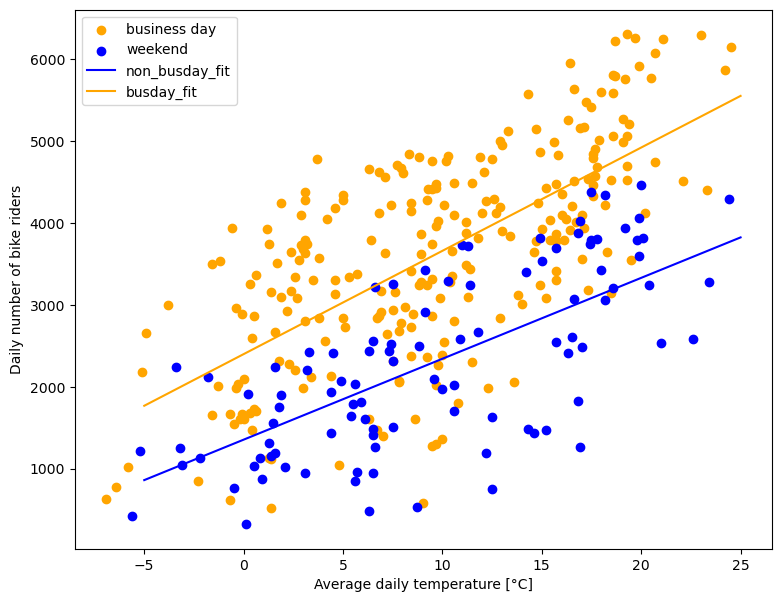

In [254]:
# plot
plt.figure(figsize=(9,7))
mplot.plot_data_and_linear_fit(
    fit_daily_counts_poisson_identity.params['Intercept'],
    fit_daily_counts_poisson_identity.params['temperature'],
    fit_daily_counts_poisson_identity.params['is_busday[T.True]'],
    fit_daily_counts_poisson_identity.params['temperature:is_busday[T.True]']
)

##### Check one of the Poisson model assumptions

Poisson distribution: Expected value equals Variance.

business days:
      mean         var  var/mean     n
0  1712.50  1064665.50    621.70   6.0
1  1976.71  1351917.24    683.92   7.0
2  2499.12   902908.80    361.29  33.0
3  3319.81   726969.56    218.98  31.0
4  3232.63  1071276.48    331.39  35.0
5  3403.35  1153585.97    338.96  46.0
6  4028.44   861547.76    213.87  25.0
7  4434.51   493822.51    111.36  41.0
8  5180.92   838629.21    161.87  24.0
9  5448.80   838144.70    153.82   5.0
non-business days:
      mean         var  var/mean     n
0   821.00   320000.00    389.77   2.0
1  1557.00   330545.50    212.30   5.0
2  1297.79   270923.57    208.76  14.0
3  1794.91   284779.89    158.66  11.0
4  1808.29   732994.47    405.35  17.0
5  2760.54   474758.60    171.98  13.0
6  2153.50  1479625.14    687.08   8.0
7  3102.72   913139.27    294.30  18.0
8  3629.00   323024.25     89.01   9.0
9  3384.33   743470.33    219.68   3.0


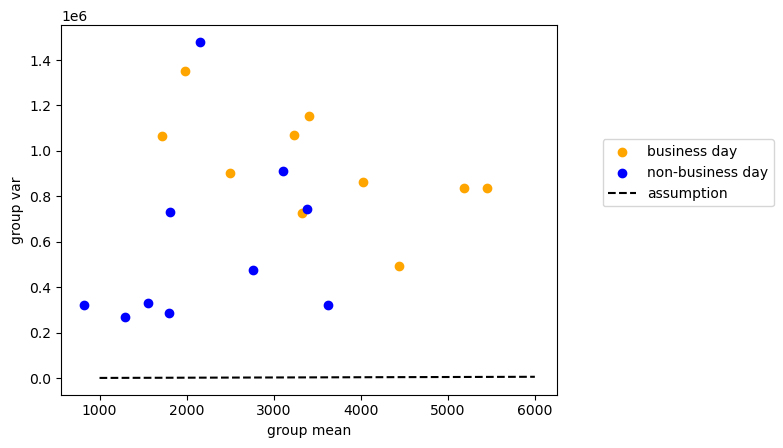

In [255]:
# extraxt data
business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == True]
non_business_day_data = combined_daily_dat[combined_daily_dat['is_busday'] == False]

# build "artificial" temperature groups and compute mean and variance in each temperature group

# number of groups
n_groups = 10

# boundaries at which to split data into temperature groups
group_boundaries = np.linspace(np.min(combined_daily_dat['temperature']),np.max(combined_daily_dat['temperature']), n_groups + 1)

# initialize storage for results (means, variances, number of datapoints in group)
means_and_var_results_business_days = np.zeros((n_groups, 4))
means_and_var_results_non_business_days = np.zeros((n_groups, 4))

# compute mean and variance in bike rider counts for each temperature group
for i in np.arange(n_groups):
    
    # extract group data
    group_data_business_days = business_day_data[(business_day_data['temperature'] >= group_boundaries[i]) & (business_day_data['temperature'] <= group_boundaries[i+1])]
    group_data_non_business_days = non_business_day_data[(non_business_day_data['temperature'] >= group_boundaries[i]) & (non_business_day_data['temperature'] <= group_boundaries[i+1])]
    
    
    # number of datapoints
    means_and_var_results_business_days[i,3] = group_data_business_days.shape[0]
    means_and_var_results_non_business_days[i,3] = group_data_non_business_days.shape[0]
        
    # if at least one datapoint in business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_business_days[i,0] = group_data_business_days['rider_count'].mean()
        
        # var
        means_and_var_results_business_days[i,1] = group_data_business_days['rider_count'].var(ddof=1)
        
        means_and_var_results_business_days[i,2] = means_and_var_results_business_days[i,1] / means_and_var_results_business_days[i,0]

    # if at least one datapoint in non-business day group
    if means_and_var_results_business_days[i,3] > 0:
        
        # mean
        means_and_var_results_non_business_days[i,0] = group_data_non_business_days['rider_count'].mean()
        
        # var
        means_and_var_results_non_business_days[i,1] = group_data_non_business_days['rider_count'].var(ddof=1)
        
        means_and_var_results_non_business_days[i,2] = means_and_var_results_non_business_days[i,1] / means_and_var_results_non_business_days[i,0]


plt.scatter(means_and_var_results_business_days[:,0], means_and_var_results_business_days[:,1], color='orange', label='business day')
plt.scatter(means_and_var_results_non_business_days[:,0], means_and_var_results_non_business_days[:,1], color='blue', label='non-business day')


# Poisson distribution assumption
plt.plot([1000., 6000.], [1000., 6000.], '--', color='black', label='assumption')

plt.xlabel('group mean')
plt.ylabel('group var')
plt.legend(bbox_to_anchor = (1.45, 0.6), loc='center right');

# print
print('business days:')
print(pd.DataFrame(np.round(means_and_var_results_business_days,2), columns = ['mean','var', 'var/mean', 'n']))
print('non-business days:')
print(pd.DataFrame(np.round(means_and_var_results_non_business_days,2), columns = ['mean','var', 'var/mean', 'n']))

Means and variances do not correspond at all. --> Assumption for Poisson Regression ia violated.

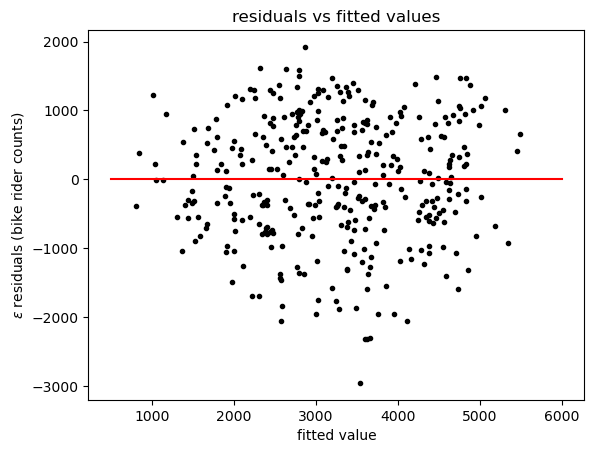

In [256]:
# inspect residuals
plt.plot(fit_daily_counts_poisson_identity.predict(combined_daily_dat), fit_daily_counts_poisson_identity.resid_response, 'k.')
plt.plot([500, 6000], 2*[0], 'r-')
plt.xlabel('fitted value')
plt.ylabel('$\epsilon$ residuals (bike rider counts)')
plt.title('residuals vs fitted values');

For Poisson distribution, the variance in residuals should get larger as the fitted value increases.